# 영화 관객수 예측 경진대회
- 주어진 데이터를 바탕으로 영화의 관객수를 예측

## 1. Library & Data Set 불러오기

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 데이터 불러오기
train = pd.read_csv('./data/movies_train.csv')
test = pd.read_csv('./data/movies_test.csv')
submission = pd.read_csv('./data/submission.csv')

In [3]:
# 한글 처리
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)

## 2. EDA

In [4]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


- title: 영화 제목
- distributor: 배급사
- genre: 장르
- release_time: 개봉일
- time: 상영시간(분)
- screening_rat: 상영등급
- director: 감독이름
- dir_prev_bfnum: 해당 감독이 영화 만들기 전 제작에 참여한 영화의 평균 관객수
- dir_prev_num: 해당 감독이 영화 만들기 전 제작에 참여한 영화 개수
- num_staff: 스텝수
- num_actor: 주연배우수
- box_off_num: 관객수

In [5]:
# 관객수 상위 10개 영화
movie_best = train.sort_values(ascending=False, by='box_off_num').head(10)
movie_best

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
372,국제시장,CJ 엔터테인먼트,드라마,2014-12-17,126,12세 관람가,윤제균,NaN,0,869,4,14262766
362,도둑들,(주)쇼박스,느와르,2012-07-25,135,15세 관람가,최동훈,2.564692e+06,3,462,10,12983841
530,7번방의 선물,(주)NEW,코미디,2013-01-23,127,15세 관람가,이환경,8.190495e+05,2,300,8,12811435
498,암살,(주)쇼박스,액션,2015-07-22,139,15세 관람가,최동훈,5.169479e+06,4,628,3,12706663
460,"광해, 왕이 된 남자",CJ 엔터테인먼트,드라마,2012-09-13,131,15세 관람가,추창민,1.552541e+06,2,402,3,12323595
122,변호인,(주)NEW,드라마,2013-12-18,127,15세 관람가,양우석,NaN,0,311,5,11374879
496,설국열차,CJ 엔터테인먼트,SF,2013-08-01,125,15세 관람가,봉준호,NaN,0,67,10,9350351
101,관상,(주)쇼박스,드라마,2013-09-11,139,15세 관람가,한재림,1.242778e+06,2,298,6,9135806
505,해적: 바다로 간 산적,롯데엔터테인먼트,SF,2014-08-06,130,12세 관람가,이석훈,1.843895e+06,3,868,2,8666208
476,수상한 그녀,CJ 엔터테인먼트,코미디,2014-01-22,124,15세 관람가,황동혁,2.781990e+06,2,437,5,8659725


<AxesSubplot:xlabel='num_staff', ylabel='box_off_num'>

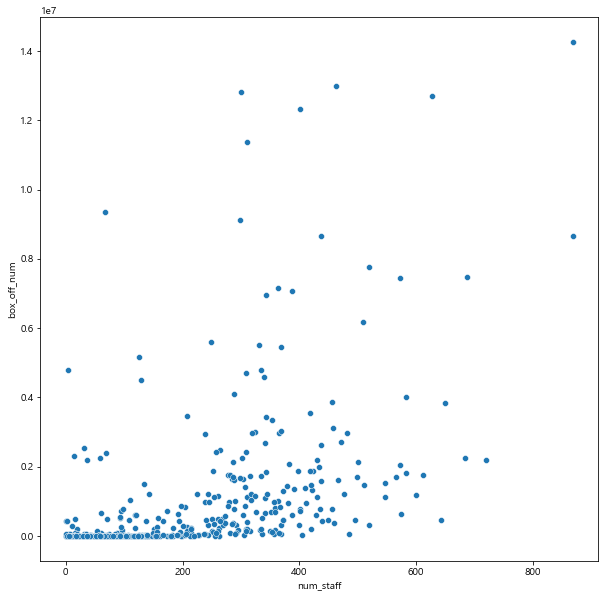

In [6]:
# 관객수 - 스텝수 그래프
plt.figure(figsize=[10, 10])
sns.scatterplot(data=train, x='num_staff', y='box_off_num')

<AxesSubplot:xlabel='time', ylabel='box_off_num'>

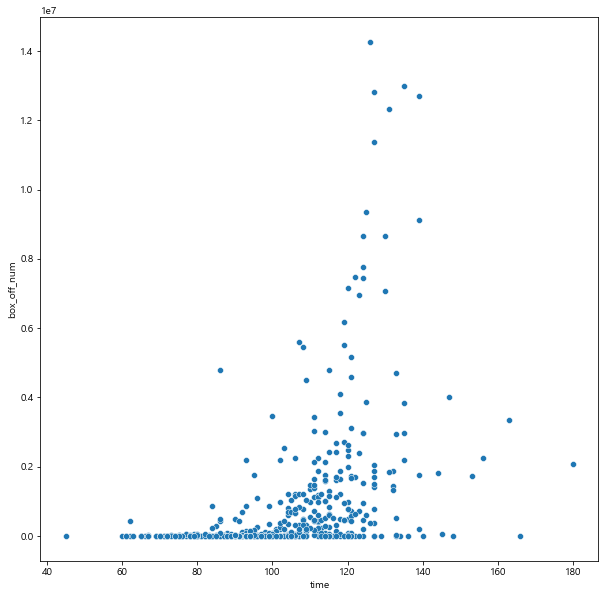

In [7]:
# 상영시간 - 관객수 그래프
plt.figure(figsize=[10, 10])
sns.scatterplot(data=train, x='time', y='box_off_num')

<AxesSubplot:xlabel='genre', ylabel='box_off_num'>

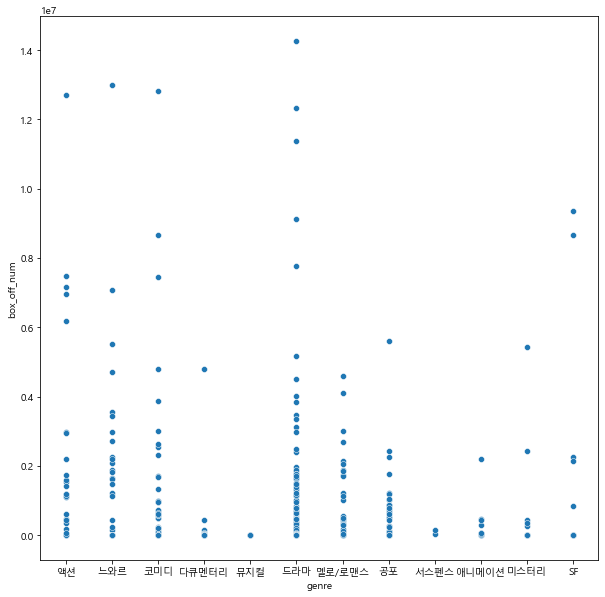

In [8]:
# 장르 - 관객수 그래프
plt.figure(figsize=[10, 10])
sns.scatterplot(data=train, x='genre', y='box_off_num')

<AxesSubplot:xlabel='num_actor', ylabel='box_off_num'>

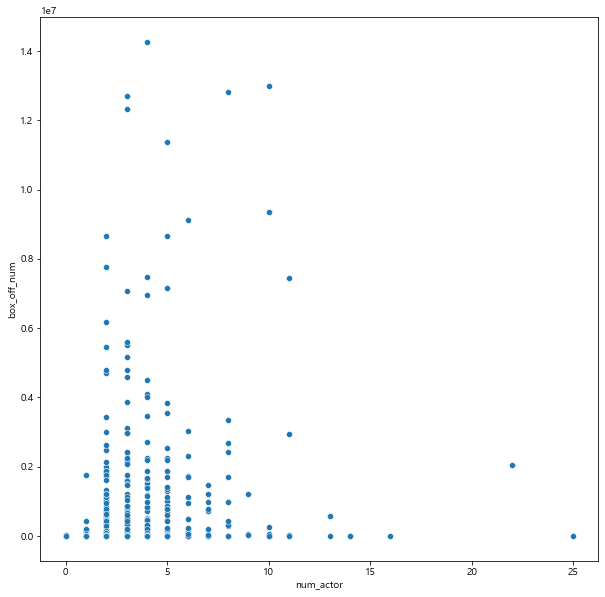

In [9]:
# 주연배우수 - 관객수 그래프
plt.figure(figsize=[10, 10])
sns.scatterplot(data=train, x='num_actor', y='box_off_num')

In [10]:
train[['title', 'box_off_num']].head()

,title,box_off_num
0,개들의 전쟁,23398
1,내부자들,7072501
2,은밀하게 위대하게,6959083
3,나는 공무원이다,217866
4,불량남녀,483387


In [11]:
test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


In [12]:
submission.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [13]:
print(train.shape)
print(test.shape)
print(submission.shape)

(600, 12)
(243, 11)
(243, 2)


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [16]:
# 상관계수
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000


<AxesSubplot:>

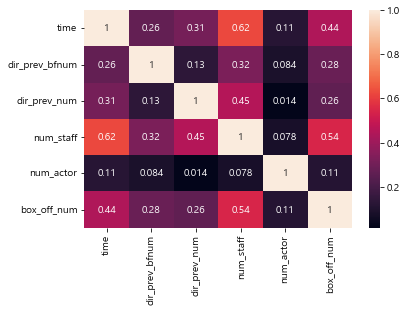

In [17]:
sns.heatmap(train.corr(), annot=True)

## 3. 데이터 전처리

### 1) 배급사 전처리
- 배급사 이름 정리 후, 배급사별 영화 관객수 중위값 기준으로 배급사 랭크 인코딩

In [18]:
train['distributor'].value_counts()

CJ 엔터테인먼트        54
롯데엔터테인먼트         52
(주)NEW           30
(주)마운틴픽쳐스        29
(주)쇼박스           26
                 ..
OAL(올)            1
(주)에이원 엔터테인먼트     1
(주)콘텐츠 윙          1
위더스필름             1
퍼스트런              1
Name: distributor, Length: 169, dtype: int64

In [19]:
# '(주)' 제거
train['distributor'] = train.distributor.str.replace('(주)', '', regex=True)
test['distributor'] = test.distributor.str.replace('(주)', '', regex=True)

In [20]:
# 특수문자 제거
train['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

In [21]:
# 같은 계열사 이름 통일
def get_dis(x):
    if 'CJ' in x or 'CGV' in x:
        return 'CJ'
    elif '쇼박스' in x:
        return '쇼박스'
    elif 'SK' in x:
        return 'SK'
    elif '리틀빅픽' in x:
        return '리틀빅픽처스'
    elif '스폰지' in x:
        return '스폰지'
    elif '싸이더스' in x:
        return '싸이더스'
    elif '에이원' in x:
        return '에이원'
    elif '마인스' in x:
        return '마인스'
    elif '마운틴픽' in x:
        return '마운틴픽쳐스'
    elif '디씨드' in x:
        return '디씨드'
    elif '드림팩트' in x:
        return '드림팩트'
    elif '메가박스' in x:
        return '메가박스'
    elif '마운틴' in x:
        return '마운틴'
    else:
        return x

In [22]:
train['distributor'] = train.distributor.apply(get_dis)
test['distributor'] = test.distributor.apply(get_dis)

In [23]:
# 배급사 랭크 인코딩
tr_nm_rank = train.groupby('distributor').box_off_num.median().reset_index(name='num_rank').sort_values(by='num_rank')
tr_nm_rank

,distributor,num_rank
110,인피니티엔터테인먼트,2.0
15,고구마공작소,8.0
52,사람과사람들,42.0
97,위드시네마,46.0
19,나우콘텐츠,54.0
...,...,...
113,전망좋은영화사,1214237.0
105,이십세기폭스코리아,1422844.0
56,쇼박스,2138560.0
84,영구아트무비,2541603.0


In [24]:
tr_nm_rank['num_rank'] = [i + 1 for i in range(tr_nm_rank.shape[0])]
tr_nm_rank

,distributor,num_rank
110,인피니티엔터테인먼트,1
15,고구마공작소,2
52,사람과사람들,3
97,위드시네마,4
19,나우콘텐츠,5
...,...,...
113,전망좋은영화사,143
105,이십세기폭스코리아,144
56,쇼박스,145
84,영구아트무비,146


### 2) 장르 전처리
- 장르별 영화 관객수 평균값으로 랭크 인코딩

In [25]:
train.groupby('genre').box_off_num.mean().sort_values()

genre
뮤지컬       6.627000e+03
다큐멘터리     6.717226e+04
서스펜스      8.261100e+04
애니메이션     1.819267e+05
멜로/로맨스    4.259680e+05
미스터리      5.275482e+05
공포        5.908325e+05
드라마       6.256898e+05
코미디       1.193914e+06
SF        1.788346e+06
액션        2.203974e+06
느와르       2.263695e+06
Name: box_off_num, dtype: float64

In [26]:
train['genre_rank'] = train.genre.map({'뮤지컬': 1, '다큐멘터리': 2, '서스펜스': 3, '애니메이션': 4, '멜로/로맨스': 5,
                                      '미스터리': 6, '공포': 7, '드라마': 8, '코미디': 9, 'SF': 10, '액션': 11, '느와르': 12})
test['genre_rank'] = test.genre.map({'뮤지컬': 1, '다큐멘터리': 2, '서스펜스': 3, '애니메이션': 4, '멜로/로맨스': 5,
                                      '미스터리': 6, '공포': 7, '드라마': 8, '코미디': 9, 'SF': 10, '액션': 11, '느와르': 12})

### 3) 최종 데이터 병합

In [27]:
train = pd.merge(train, tr_nm_rank, how='left')
test = pd.merge(test, tr_nm_rank, how='left')

In [28]:
# 결측값 처리
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

## 4. 변수 선택

### 1) 모델링 데이터 구성
- 타겟 값인 관객수를 로그변환 (정규분포)
- 상영등급은 더미변수
- 출연 배우 수는 로그변환

In [29]:
X = train[['num_rank', 'time', 'num_staff', 'num_actor', 'genre_rank', 'screening_rat']]
y = np.log1p(train.box_off_num)

In [30]:
X = pd.get_dummies(columns=['screening_rat'], data=X)

In [31]:
X['num_actor'] = np.log1p(X['num_actor'])

In [32]:
target = test[['num_rank', 'time', 'num_staff', 'num_actor', 'genre_rank', 'screening_rat']]
target = pd.get_dummies(columns=['screening_rat'], data=target)
target['num_actor'] = np.log1p(X['num_actor'])

### 2) 10Fold로 교차검증

In [33]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

## 5. 모델링

In [34]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from ngboost import NGBRegressor

### 1) GradientBoostingRegressor

In [35]:
gbm = GradientBoostingRegressor(random_state=42)

In [36]:
rmse_list = []
gb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y):
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    gbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in gbm.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in gbm.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    rmse_list.append(rmse)
    
    gb_pred += (sub_pred / 10)

In [37]:
gb_rmse = np.mean(rmse_list)
gb_rmse

1174378.9765191542

In [38]:
submission['box_off_num'] = gb_pred
submission.sort_values(by='box_off_num')

,title,box_off_num
20,인플루언스,2.647017e+00
130,댄서김의 은밀한 교수법,2.725356e+00
39,REC 알이씨,4.243058e+00
139,화려한 외출,5.382258e+00
24,탈주,5.490257e+00
...,...,...
135,용의자,4.051840e+06
229,베테랑,4.568104e+06
142,박수건달,5.807990e+06
179,군도: 민란의 시대,7.664061e+06


In [39]:
submission.to_csv('./result/gb.csv', index=False)

### 2) NGBRegressor

In [40]:
ngb = NGBRegressor(random_state=518)

In [41]:
rmse_list = []
ngb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y):
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    ngb.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in ngb.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in ngb.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    rmse_list.append(rmse)
    
    ngb_pred += (sub_pred / 10)

[iter 0] loss=2.6200 val_loss=0.0000 scale=1.0000 norm=2.9523
[iter 100] loss=1.9566 val_loss=0.0000 scale=2.0000 norm=2.7106
[iter 200] loss=1.5812 val_loss=0.0000 scale=2.0000 norm=2.1869
[iter 300] loss=1.4423 val_loss=0.0000 scale=2.0000 norm=2.0889
[iter 400] loss=1.3728 val_loss=0.0000 scale=1.0000 norm=1.0177
[iter 0] loss=1.4114 val_loss=0.0000 scale=1.0000 norm=1.0788
[iter 100] loss=1.3286 val_loss=0.0000 scale=1.0000 norm=1.0104
[iter 200] loss=1.2881 val_loss=0.0000 scale=1.0000 norm=0.9877
[iter 300] loss=1.2453 val_loss=0.0000 scale=1.0000 norm=0.9646
[iter 400] loss=1.2103 val_loss=0.0000 scale=0.5000 norm=0.4740
[iter 0] loss=1.2153 val_loss=0.0000 scale=1.0000 norm=0.9552
[iter 100] loss=1.1647 val_loss=0.0000 scale=0.2500 norm=0.2298
[iter 200] loss=1.1564 val_loss=0.0000 scale=0.1250 norm=0.1141
[iter 300] loss=1.1457 val_loss=0.0000 scale=0.5000 norm=0.4534
[iter 400] loss=1.1403 val_loss=0.0000 scale=0.0078 norm=0.0071
[iter 0] loss=1.1708 val_loss=0.0000 scale=1.0

In [42]:
ngb_rmse = np.mean(rmse_list)
ngb_rmse

1336763.4092477798

In [43]:
submission['box_off_num'] = ngb_pred
submission.sort_values(by='box_off_num')

,title,box_off_num
39,REC 알이씨,1.046361e-01
20,인플루언스,1.277107e-01
167,바리새인,2.461225e-01
234,슬픈남자,3.626936e-01
65,엄마는 창녀다,4.604966e-01
...,...,...
229,베테랑,4.474201e+06
135,용의자,5.076025e+06
142,박수건달,6.201829e+06
178,명량,8.068364e+06


In [44]:
submission.to_csv('./result/ngb.csv', index=False)

### 3) LGBMRegressor

In [45]:
lgbm = LGBMRegressor(random_state=518)

In [46]:
rmse_list = []
lgbm_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y):
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    lgbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    rmse_list.append(rmse)
    
    lgbm_pred += (sub_pred / 10)

In [47]:
lgbm_rmse = np.mean(rmse_list)
lgbm_rmse

1213815.0440528719

In [48]:
submission['box_off_num'] = lgbm_pred
submission.sort_values(by='box_off_num')

,title,box_off_num
39,REC 알이씨,6.006902e+01
130,댄서김의 은밀한 교수법,6.083224e+01
173,옹녀뎐,9.022447e+01
139,화려한 외출,9.372773e+01
143,배꼽,1.058136e+02
...,...,...
179,군도: 민란의 시대,6.014808e+06
229,베테랑,6.474746e+06
61,수상한 고객들,6.476403e+06
178,명량,6.589275e+06


In [49]:
submission.to_csv('./result/lgbm.csv', index=False)

### 4) XGBRegressor

In [50]:
xgb = XGBRegressor(random_state=518)

In [51]:
rmse_list = []
xgb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y):
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    xgb.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in xgb.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in xgb.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    rmse_list.append(rmse)
    
    xgb_pred += (sub_pred / 10)

In [52]:
xgb_rmse = np.mean(rmse_list)
xgb_rmse

1437735.1546705803

In [53]:
submission['box_off_num'] = xgb_pred
submission.sort_values(by='box_off_num')

,title,box_off_num
20,인플루언스,8.230798e-01
234,슬픈남자,1.758980e+00
173,옹녀뎐,2.047489e+00
47,고래를 찾는 자전거,2.140532e+00
95,천국의 아이들,2.317331e+00
...,...,...
158,우는 남자,3.480028e+06
179,군도: 민란의 시대,3.977340e+06
178,명량,4.355552e+06
135,용의자,4.774083e+06


In [54]:
submission.to_csv('./result/xgb.csv', index=False)

### 5) CatBoostRegressor

In [55]:
cat = CatBoostRegressor(random_state=518, silent=True)

In [56]:
rmse_list = []
cat_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y):
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    cat.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in cat.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in cat.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    rmse_list.append(rmse)
    
    cat_pred += (sub_pred / 10)

In [57]:
cat_rmse = np.mean(rmse_list)
cat_rmse

1075600.9209088846

In [58]:
submission['box_off_num'] = cat_pred
submission.sort_values(by='box_off_num')

,title,box_off_num
39,REC 알이씨,9.008297e+00
167,바리새인,9.483717e+00
139,화려한 외출,1.005426e+01
20,인플루언스,1.071599e+01
130,댄서김의 은밀한 교수법,1.202435e+01
...,...,...
61,수상한 고객들,3.708812e+06
108,신세계,3.730411e+06
179,군도: 민란의 시대,3.824351e+06
178,명량,4.647236e+06


In [59]:
submission.to_csv('./result/cat.csv', index=False)

### 6) RandomForestRegressor

In [60]:
rf = RandomForestRegressor(random_state=518)

In [61]:
rmse_list = []
rf_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y):
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    rf.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in rf.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in rf.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    rmse_list.append(rmse)
    
    rf_pred += (sub_pred / 10)

In [62]:
rf_rmse = np.mean(rmse_list)
rf_rmse

872738.262092494

In [63]:
submission['box_off_num'] = rf_pred
submission.sort_values(by='box_off_num')

,title,box_off_num
167,바리새인,8.618484e+00
20,인플루언스,9.043904e+00
65,엄마는 창녀다,9.261489e+00
139,화려한 외출,9.395990e+00
124,콩가네,9.503248e+00
...,...,...
229,베테랑,2.547155e+06
135,용의자,3.020335e+06
179,군도: 민란의 시대,3.267259e+06
61,수상한 고객들,3.486543e+06


In [64]:
submission.to_csv('./result/rf.csv', index=False)

### 7) 최종 예측 결과 블렌딩

In [65]:
submission['box_off_num'] = (rf_pred + cat_pred + xgb_pred + lgbm_pred + ngb_pred + gb_pred) / 6
submission.sort_values(by='box_off_num')

,title,box_off_num
39,REC 알이씨,1.430182e+01
130,댄서김의 은밀한 교수법,1.492204e+01
139,화려한 외출,2.149689e+01
173,옹녀뎐,2.210663e+01
20,인플루언스,2.212502e+01
...,...,...
142,박수건달,4.439445e+06
61,수상한 고객들,4.457677e+06
135,용의자,4.824677e+06
179,군도: 민란의 시대,5.524700e+06


In [66]:
submission.to_csv('./result/all.csv', index=False)

## 6. 최종 결과 시각화

In [67]:
score = {'gb': gb_rmse, 'ngb': ngb_rmse, 'lgbm': lgbm_rmse, 'xgb': xgb_rmse, 'cat': cat_rmse, 'rf': rf_rmse}
score

{'gb': 1174378.9765191542,
 'ngb': 1336763.4092477798,
 'lgbm': 1213815.0440528719,
 'xgb': 1437735.1546705803,
 'cat': 1075600.9209088846,
 'rf': 872738.262092494}

In [68]:
result = pd.DataFrame.from_dict(score, orient='index')
result.reset_index(level=0, inplace=True)
result.columns = ['model', 'rmse']
result

,model,rmse
0,gb,1.174379e+06
1,ngb,1.336763e+06
2,lgbm,1.213815e+06
3,xgb,1.437735e+06
4,cat,1.075601e+06
5,rf,8.727383e+05


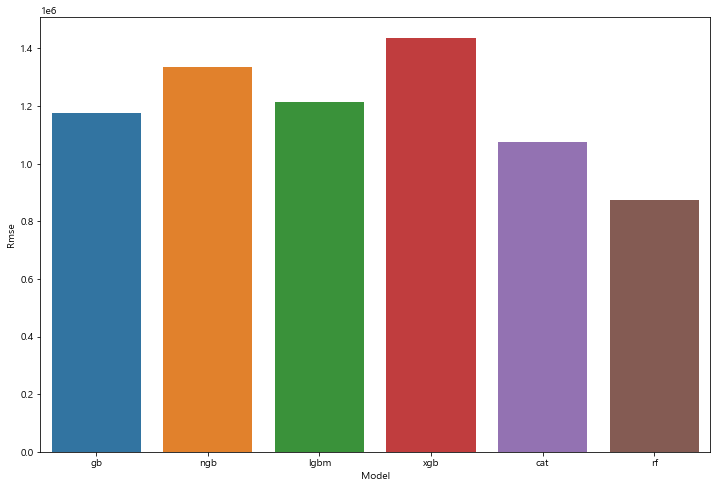

In [69]:
plt.figure(figsize=[12, 8])
sns.barplot(data=result, x='model', y='rmse')

plt.xlabel('Model')
plt.ylabel('Rmse')
plt.show()